В Примерах 1 и 2 мы познакомимся с вычислиением скорректированного коэффициента детерминации и его смыслом

В Примере 3 увидим, почему нельзя в линейной регрессии доверять экстраполяции

В Примере 4 изучим один из способов обнаружить нелинейную зависимость между фактором и целевой переменной

In [1]:
# импорт библиотек и датасета
%pylab inline
import numpy as np
import pandas as pd
import math as mt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

Populating the interactive namespace from numpy and matplotlib


Пример 1

Вычислим обычный и скорректированный коэффициенты детерминации для разных моделей линейных регрессий на примере Boston Housing и посмотрим, как они будут различаться на обучающей и тестовой выборках.

In [2]:
# загрузим датасет Boston Housing
boston = datasets.load_boston()
bostonDF = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

In [3]:
# добавим мусорный признак в датасет - случайный целочисленный вектор со значениями от 0 до 10
bostonDF['TRASH'] = pd.Series(np.random.randint(0,10,506))

In [4]:
# разделим датасет на обучающую и тестовую выборки
# параметр random_state обещает, что каждый раз, когда мы запустим команду, результат деления на train и test будет одинаковым
# вы можете проверить это, запустив блок несколько раз
# зададим размер тренировочной выборки 90%
X_train, X_test, y_train, y_test = train_test_split(bostonDF, y, train_size=0.9, random_state=151)
# любуемся на кусочек результата
X_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TRASH
119,0.14476,0.0,10.01,0.0,0.547,5.731,65.2,2.7592,6.0,432.0,17.8,391.50,13.61,4
116,0.13158,0.0,10.01,0.0,0.547,6.176,72.5,2.7301,6.0,432.0,17.8,393.30,12.04,1
200,0.01778,95.0,1.47,0.0,0.403,7.135,13.9,7.6534,3.0,402.0,17.0,384.30,4.45,9
163,1.51902,0.0,19.58,1.0,0.605,8.375,93.9,2.1620,5.0,403.0,14.7,388.45,3.32,0
105,0.13262,0.0,8.56,0.0,0.520,5.851,96.7,2.1069,5.0,384.0,20.9,394.05,16.47,9


Создадим функцию regscores, которая будет вычислять обычные и исправленные коэффициенты детермианции для тренировочной и тестовой выборок

Ее параметры:

factors - список столбцов датасета, по которым мы будем прогонять регрессию

X_train, X_test, y_train, y_test - тренировочные и тестовые части датасета

In [5]:
def regscores(factors, X_train, X_test, y_train, y_test):
    
    # данные, на которых будет обучаться и тестироваться модель
    Data_train = X_train[factors]
    Data_test = X_test[factors]
    
    k = len(factors) # количество признаков (без константы)
    N_train = Data_train.shape[0] # размер обучающей выборки
    N_test = Data_test.shape[0] # размер тестовой вбыорки
    
    # обучим регрессию и интерсептом на тренировочной выборке
    # параметр fit_intercept =True можно не указывать, он установлен по умолчанию
    reg = LinearRegression(fit_intercept =True).fit(Data_train, y_train)

    # сделаем пердсказания на обучающей и тестовой выборках
    y_train_pred = reg.predict(Data_train)
    y_test_pred = reg.predict(Data_test)
    
    # создадим выходной вектор, в который будем записывать результат
    r2 = np.zeros(4)
    
    # R-squared для тренировочной выборки
    # (можно использовать reg.score, не импортируя отдельно r2_score)
    r2[0] = r2_score(y_train,y_train_pred)
    # R-squared adjusted для тренировочной выборки
    r2[1] = 1 - (1 - r2[0])*(N_train-1)/(N_train-k)
    
    # R-squared для тестовой выборки
    r2[2] = r2_score(y_test,y_test_pred)
    # R-squared adjusted для тестовой выборки
    r2[3] = 1 - (1 - r2[2])*(N_test-1)/(N_test-k)
    

    
    return r2

In [6]:
print('Модель с 2 факторами')
list_col=['CRIM', 'RM']
R2 = regscores(list_col, X_train, X_test, y_train, y_test)
print('R-squared для тренировочной выборки = ', R2[0])
print('R-squared adj для тренировочной выборки = ', R2[1])
print('R-squared для тестовой выборки = ', R2[2])
print('R-squared adj для тестовой выборки = ', R2[3])

Модель с 2 факторами
R-squared для тренировочной выборки =  0.5411573486678409
R-squared adj для тренировочной выборки =  0.5401444509827811
R-squared для тестовой выборки =  0.5461583309331364
R-squared adj для тестовой выборки =  0.5368962560542208


Выводы:

1. Коэффициенты детерминации на тренировочной и тестовой выборке примерно одинаковые, а это значит, что модель не переобучилась
2. R-sq > R-sq adj
3. На тренировочной выборке разница между  R-sq и R-sq adj невелика. Так происходит, потому что размер выборки большой (около 450 точек), а факторов всего 2 - отношение (N-1)/(n-k) будет мало отличаться от 1, а значит и значения коэффициентов детерминации будут близки
4. Подумайте, почему на тестовой выборке R-sq и R-sq adj отличаются более заметно?

In [7]:
print('Модель с 2 факторами и мусорным фактором')
list_col=['CRIM', 'RM','TRASH']
R2 = regscores(list_col, X_train, X_test, y_train, y_test)
print('R-squared для тренировочной выборки = ', R2[0])
print('R-squared adj для тренировочной выборки = ', R2[1])
print('R-squared для тестовой выборки = ', R2[2])
print('R-squared adj для тестовой выборки = ', R2[3])

Модель с 2 факторами и мусорным фактором
R-squared для тренировочной выборки =  0.5412367663885402
R-squared adj для тренировочной выборки =  0.5392068405761001
R-squared для тестовой выборки =  0.5448284451865084
R-squared adj для тестовой выборки =  0.5258629637359462


Выводы:

1. Коэффициенты детерминации на тренировочной и тестовой выборке примерно одинаковые, и это значит, что модель не переобучилась
2. R-sq < R-sq adj
3. R-sq на обеих выборках чуть выше, чем в модели без мусорного фактора
4. R-sq adj на тренировочной выборке отличаются совсем немного. Подумайте, почему?
5. R-sq adj на тестовой выборке заметно меньше, чем на тренировочной. Это значит, что R-sq adj "поймал" нас на добавлении "лишнего" фактора.

In [8]:
list_col=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD','TAX', 
       'PTRATIO', 'B', 'LSTAT']
R2  = regscores(list_col, X_train, X_test, y_train, y_test)
print('R-squared для тренировочной выборки = ', R2[0])
print('R-squared adj для тренировочной выборки = ', R2[1])
print('R-squared для тестовой выборки = ', R2[2])
print('R-squared adj для тестовой выборки = ', R2[3])

R-squared для тренировочной выборки =  0.7385649945730068
R-squared adj для тренировочной выборки =  0.7314672116202378
R-squared для тестовой выборки =  0.7469385377753862
R-squared adj для тестовой выборки =  0.6670243918097187


In [9]:
list_col=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT','TRASH']
R2 = regscores(list_col, X_train, X_test, y_train, y_test)
print('R-squared для тренировочной выборки = ', R2[0])
print('R-squared adj для тренировочной выборки = ', R2[1])
print('R-squared для тестовой выборки = ', R2[2])
print('R-squared adj для тестовой выборки = ', R2[3])

R-squared для тренировочной выборки =  0.7385651450532837
R-squared adj для тренировочной выборки =  0.7308584486489588
R-squared для тестовой выборки =  0.7468718241377974
R-squared adj для тестовой выборки =  0.65793489748351


Выводы для моделей с большим количеством факторов:

1. Взяли в модель все имеющиеся факторы. R-sq на train и test отличаются незначительно, а R-sq adj - существенно, около 8%. Дело в том, что данных в тестовой выборке немного, около 50, а факторов много - 13 (или 14). Из-за этого R-sq adj существенно отличается от R-sq на тестовой выборке.

Общие выводы:

1. Если данных немного, то R-sq adj - более точная метрика качества прогнозирующей способности регрессии, так как она учтет количество факторов
2. Если данных много (существенно больше, чем факторов), нет большой разницы, что использовать - R-sq или R-sq adj, они будут почти одинаковыми
    

Важное замечание:

Все классные свойства коэффициентов детерминации работают только для моделей с intercept! В модели без intersept R-sq перестает показывать долю объясненной дисперсии.

Пример 2

Посмотрим, как визуально выглядят регрессии с большим и маленьким R-squared

Очень высокий коэффициент детерминации:
R-squared =  0.9994728978866527


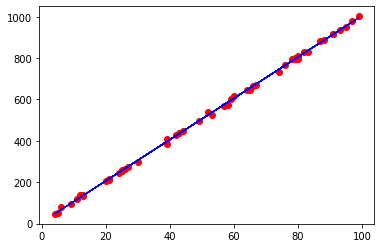

In [10]:
print('Очень высокий коэффициент детерминации:')
# зададим случайным образом вектор признака а
a = np.random.randint(1,100, 50)

# зададим линейную зависимость между y и а
y=5+10*a+np.random.normal(0,7,len(a))

# преобразуем а для LinearRegression
adf=pd.DataFrame(a)

# прогоним регрессию
reg = LinearRegression(fit_intercept =True).fit(adf, y)

# найдем коэффициент детерминации
print('R-squared = ',reg.score(adf,y))

# нарисуем картинку: линия означает регрессионную прямую, точки - настоящие данные
y_pred=reg.predict(adf)
plt.scatter(a, y,  color='red')
plt.plot(a, y_pred, color='blue', linewidth=1)

Менее высокий коэффициент детерминации:
R-squared =  0.8810724883920309


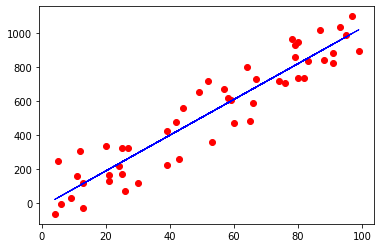

In [11]:
print('Менее высокий коэффициент детерминации:')
#  добавим еще одну переменную
b = np.random.randint(-40,40, 50)

# усложним зависимость y от  а, b
y=5+10*a+5*b+np.random.normal(0,7,len(a))

# прогоним регрессию и выведем результаты
adf=pd.DataFrame(a)
reg = LinearRegression(fit_intercept =True).fit(adf, y)
print('R-squared = ',reg.score(adf,y))
y_pred=reg.predict(adf)
plt.scatter(a, y,  color='red')
plt.plot(a, y_pred, color='blue', linewidth=1)

Вывод:

1. Чем больше коэффициент детерминации, тем более кучно расположены точки вокруг регрессионной прямой, и, следовательно, тем выше качество предсказания

Пример 3

Интерполяция и экстраполяция  
Идея состоит в том, что в моделях простой линейной регрессии (не во временных рядах) мы можем хорошо прогнозировать ТОЛЬКО ВНУТРИ интервалов разброса признаков.

In [12]:
# создадим массив чисел от -0.4 до 2 с равным шагом 0.02
a = np.arange(-20,101)/50
# зададим теоретическую зависимость y(a) =  синус + случайная нормальная ошибка с нулевым средним и ст. отклонением 0.1
y = np.sin(a) + np.random.normal(0,0.1,len(a))

In [13]:
# разделим данные на две группы: группа inter - значения a от -0.2 до 0.8, группа extra - все остальные значения
a_inter = pd.DataFrame(a[0:60])
y_inter = y[0:60]
a_extra = pd.DataFrame(a[61:len(a)-1])
y_extra = y[61:len(a)-1]


R-squared =  0.8958363000669614


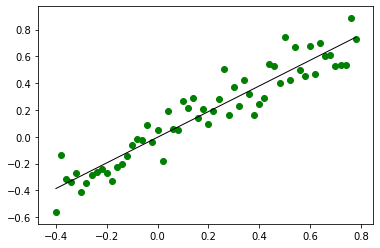

In [14]:
# обучим регрессию на группе inter
reg = LinearRegression(fit_intercept =True).fit(a_inter, y_inter)
print('R-squared = ',reg.score(a_inter, y_inter))
y_pred=reg.predict(a_inter)
# нарисуем картинку
plt.scatter(a_inter, y_inter,  color='green')
plt.plot(a_inter, y_pred, color='black', linewidth=1)

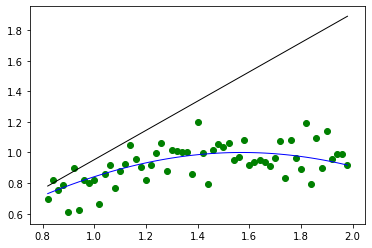

In [15]:
# попробуем сделать предсказания на группе extra
y_pred_ex=reg.predict(a_extra)
plt.scatter(a_extra, y_extra,  color='green') # точки
plt.plot(a_extra, y_pred_ex, color='black', linewidth=1) # ожидание (предсказания модели)
plt.plot(a_extra, sin(a_extra), color='blue', linewidth=1) # реальность (настоящие данные)

На группе inter мы получили идеальную прямую с высоким R-sq. Как только попробовали сделать экстраполяцию - предсказания за пределами отрезка [-0.2, 0.8], модель резко перестала работать.

Почему так получилось?

Дело в том, что мы уверены в точности прогноза (благодяра высокому R-sq) ТОЛЬКО ВНУТРИ отрезка, на котором обучали регрессию - [-0.2,0.8] Что произойдет с теоретической зависимостью ЗА пределами этого отрезка, мы, находясь в нем, не знаем! В нашем случае на отрезке [-0.2, 0.8] синус ведет себя практически как линейная функция, что и дает нам красивую регрессию. Однако дальше он проявляет во всей красе свою нелинейность и модель больше не валидна.

Пример 4

Как можно понять, что линейная модель не подходит к данным?

1. Построить scatter plot (y,factor) - по нему можно предположить тренд (линейный, квадратичный, экспоненциальный итп)
2. Построить scatter plot остатков регрессионной модели - в нем не должно быть явных паттернов, тогда линейная модель годится

In [16]:
# создадим массив чисел от -0.2 до 2 с равным шагом 0.02
a = np.arange(-20,80)/50
# зададим теоретическую зависимость y(a) =  синус + случайная нормальная ошибка с нулевым средним и ст. отклонением 0.1
y = np.sin(a) + np.random.normal(0,0.1,len(a))

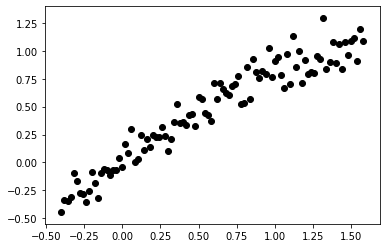

In [17]:
# способ 1
# по графику не очень ясно видно, есть нелинейность или нет 
plt.scatter(a, y,  color='black')

R-squared =  0.9188930236617376


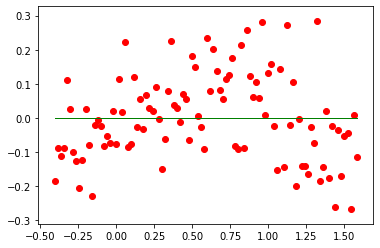

In [18]:
# Способ 2
# обучим все регрессию и посмотрим на картинку остатков
adf=pd.DataFrame(a)
reg = LinearRegression(fit_intercept =True).fit(adf, y)
print('R-squared = ',reg.score(adf, y))
y_pred = reg.predict(adf)
residuals = y - y_pred
# нарисуем картинку
zero = np.zeros(len(a))
plt.scatter(adf, residuals,  color='red')
plt.plot(adf,zero, color='green', linewidth=1)

Мы видим, что в левой и правой части графика остатков почти все точки расположены ниже нулевой отметки, а в середине - выше.

Это и есть закономерность - нелинейный паттерн. Линейная модель неприменима

In [20]:
boston_train = pd.read_csv('boston_train.csv')

In [21]:
boston_test = pd.read_csv('boston_test.csv')

In [22]:
list_col=['LSTAT', 'NOX']
R2  = regscores(list_col, boston_train, boston_test, boston_train['PRICE'], boston_test['PRICE'])
print('R-squared для тренировочной выборки = ', R2[0])
print('R-squared adj для тренировочной выборки = ', R2[1])
print('R-squared для тестовой выборки = ', R2[2])
print('R-squared adj для тестовой выборки = ', R2[3])

R-squared для тренировочной выборки =  0.5428462871743152
R-squared adj для тренировочной выборки =  0.5418371178303292
R-squared для тестовой выборки =  0.5586456733224683
R-squared adj для тестовой выборки =  0.549638442165784
